In [11]:
## imports for the program
import os
import io
import csv
import zlib
import copy
import math
import time
import pickle
import base64
import joblib
import hashlib
import platform
import warnings

import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm
from xgboost import plot_importance
from scipy.optimize import fmin_powell

# plot information in 3 dimensions
# from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import kaleido
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN, MeanShift, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, confusion_matrix, accuracy_score, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LinearRegression

# the pytorch module
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

# torch neural network items
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# for visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# lime model evaluation
from lime import lime_tabular

# for encrypting the model and hashing it
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.scrypt import Scrypt
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives.asymmetric import padding
from cryptography.fernet import Fernet, MultiFernet




# code for xgboost found at https://www.kaggle.com/code/zeroblue/xgboost-with-optimized-offsets

# defining the device for cuda
if platform.system() == 'Darwin' and torch.backends.mps.is_available():
	
	# check if mps is available on mac
	device = torch.device('mps')  

elif torch.cuda.is_available():
	
	# check if cuda is available
    device = torch.device('cuda')  

else:
	
	# fallback to cpu if cuda is not available
	device = torch.device('cpu')  

# output the selected device
print(f"Using device: {device}")


Using device: mps


In [12]:
# global directory path
HOME_DIR = os.path.expanduser('~')

# the sub directory from the home direcotry
SUB_DIR = "Desktop/Classes/CPSC 471/Final Project/"

# directory that we should write info to
OUT_DIR = "models/node_importance_delta"

# where we are writing files to
WRITE_DIR = os.path.join(
	HOME_DIR,
	SUB_DIR,
	OUT_DIR
)

BASELINE_SAVE_FILE_NAME = "manipulate_nn.pth"

# check if we are running pca or normal
TRAIN_PCA = True

# get the batch size
BATCH_SIZE = 64

# the number of times that we are going to run the importance-reduction to get 
# the average time for the operation
RUN_TIMES = 5

MAX_INDICIES_LEN_PLOTTING = 500

# getting the colors for the plots 
PLOT_COLOR_1 = "darkorange"
PLOT_COLOR_2 = "dodgerblue"

# whether we should save the images
SHOULD_SAVE_OUTPUT = True
NUM_CLASSES = 10

In [13]:
# load the data
print("Load the data using pandas")
train = pd.read_csv("../final_471_datasets/train.csv")
test = pd.read_csv("../final_471_datasets/test.csv")

# global variables
columns_to_drop = ['Id', 'Response'] #, 'Medical_History_10','Medical_History_24']
xgb_num_rounds = 720
missing_indicator = -1000

# training and testing temp dataframes
temp_train = train
temp_test = test

# getting all of the data
all_data = pd.concat([temp_train, temp_test], ignore_index=True)

# create new variable for product first and second character
all_data['Product_Info_2'] = all_data.Product_Info_2.astype(str)
all_data['Product_Info_2_char'] = all_data["Product_Info_2"].str[0]
all_data['Product_Info_2_num'] = all_data["Product_Info_2"].str[1]

# factorize the categorical variables
all_data['Product_Info_2'] = pd.factorize(all_data['Product_Info_2'])[0]
all_data['Product_Info_2_char'] = pd.factorize(all_data['Product_Info_2_char'])[0]
all_data['Product_Info_2_num'] = pd.factorize(all_data['Product_Info_2_num'])[0]

# get the combined BMI age variable
all_data['BMI_Age'] = all_data['BMI'] * all_data['Ins_Age']

# checking for how many medical keywords were found in each patient diagnosis
med_keyword_columns = all_data.columns[all_data.columns.str.startswith('Medical_Keyword_')]
all_data['Med_Keywords_Count'] = all_data[med_keyword_columns].sum(axis=1)

# remove the missing values
print('Eliminate missing values')    
all_data.fillna(missing_indicator, inplace=True)

# fix the dtype on the label column
all_data['Response'] = all_data['Response'].astype(int)

# split train and test
train = all_data[all_data['Response']>0].copy()
test = all_data[all_data['Response']<1].copy()


Load the data using pandas
Eliminate missing values


In [14]:
# now create a neural network without any of the explainability features that we want to integrate

# just pull the data from before
train_data = all_data[all_data['Response'] > 0].copy()
test_data = all_data[all_data['Response'] < 1].copy()

# split the data into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    train_data.drop(columns=columns_to_drop, axis=1),
    train_data['Response'],
    test_size=0.2,
    random_state=42
)

# scale the data appropriately
scaler = StandardScaler()

# fit and transform the data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# load the insurance dataset in 
class InsuranceDataset(Dataset):

    # initialize the features and the labels
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    # define the length function
    def __len__(self):
        return len(self.features)

    # get the item defined by an index
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long) - 1  # Assuming labels are 1-indexed


# define an object for the insurance test and train datasets
train_dataset = InsuranceDataset(X_train_scaled, y_train.values)
val_dataset = InsuranceDataset(X_val_scaled, y_val.values)
test_dataset = train_dataset

# include the validation dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = test_dataset






# compute the principal components of the data that we are trying to train the machine learning model on 
# all_data: this is all of the data that we are going to run the principal component analysis on
# n_components: the number of components that the PCA should generate for us
# should_scale: this defines whether we should scale the data that we are considering or not using the standard scaler
def compute_PCA(all_data, n_components=10, scale_data=False):

    # check the data type to make sure that it is good
    if not isinstance(all_data, torch.Tensor):
        all_data = torch.tensor(all_data, dtype=torch.float)

    # compute the principal components
    if scale_data:
        std_scaler = StandardScaler()
        all_data = std_scaler.fit_transform(all_data)

    # run the pca
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(all_data)

    # return the principal components
    return pca, torch.from_numpy(principal_components).float()




# function for getting all of the features of the data together for computation
def get_all_features(train_loader):

    # get the matrix that we are going to be using to compute the mahalanobis distance
    # start by getting all of the data from the loader
    features_list = []
    labels_list = []

    for features, labels in tqdm(train_loader, desc="Retrieving data from loader"):
        features_list.append(features)
        labels_list.append(labels)

    # concatenate all of the inputs that we are going to be using together
    all_features = torch.cat(features_list, dim=0)

    # get a tensor out of it
    all_features = all_features.clone().detach()
    
    # concatenate all of the inputs that we are going to be using together
    all_labels = torch.cat(labels_list, dim=0)
    all_labels = all_labels.clone().detach()

    return (all_features, all_labels)


# function to visualize the PCA so that we can better understand the data that we are training on
def visualize_pca(pca_features, labels, centroids):

    # transfer the labels to numpy
    labels = np.array(labels)
    
    # class colors
    matplotlib_colors = [
        'b',  
        'g',  
        'r',  
        'c',  
        'm',  
        'y',  
        'orange',
        'purple',
        'brown',
        'pink',
        'gray',
        'olive',
        'cyan',
        'lime',
        'maroon',
        'navy',
        'teal',
        'coral'
    ]

    # get the number of labels that we are going to plot
    # print(f"Number of labels: {len(set(labels))}")

    # get the number of components that we are ploting
    num_components = pca_features.shape[1]
    num_plots = num_components // 3

    # create subplots
    for plot_index in range(num_plots):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # getting the compoennts that we ar egoing to be plotting
        component_start = plot_index * 3
        component_end = component_start + 3

        # create the figure
        fig = go.Figure()

        # plot the PCA figures
        for label in tqdm(set(labels), desc=f"Plotting labeled data points in subplot {plot_index}"):

            # get all of the points from a certain label
            indices = np.where(labels == label)[0]

            # sample a maximum number of the points
            if len(indices) > MAX_INDICIES_LEN_PLOTTING:
                indices = np.random.choice(indices, MAX_INDICIES_LEN_PLOTTING, replace=False)

            # print(f"Plotting {len(indices)} points for label {label} in subplot {plot_index}...")

            # fix the label features to fix it if we had too. many
            label_features = pca_features[indices, component_start:component_end]

            # plot the dots
            try:
                # plt.scatter(label_features[:, 0], 
                #             label_features[:, 1], 
                #             color=matplotlib_colors[label], 
                #             label=f'Class {label}', 
                #             s=10)

                fig.add_trace(go.Scatter3d(
                    x=label_features[:, 0], 
                    y=label_features[:, 1], 
                    z=label_features[:, 2],
                    mode='markers',
                    marker=dict(size=3),
                    name=f'Class {label}'
                ))
            except Exception as e:
                print(f"Failed: {e}")
        
        # plot the centroids to show where they are
        for i, centroid in enumerate(centroids):
            if centroid.shape[0] > component_end:
                fig.add_trace(go.Scatter3d(
                    x=[centroid[component_start]],
                    y=[centroid[component_start+1]],
                    z=[centroid[component_start+2]],
                    mode='markers',
                    marker=dict(symbol='x', size=5, color='black'),
                    name=f'Centroid {i + 1}'
                ))
                # print(f'Centroid {i + 1} at {centroid[component_start]} {centroid[component_start+1]} {centroid[component_start+2]}')

        # put the information on the plots
        # ax.set_title(f'3D PCA Plot of Components {component_start+1} to {component_end}')
        # ax.set_xlabel('Component {}'.format(component_start + 1))
        # ax.set_ylabel('Component {}'.format(component_start + 2))
        # ax.set_zlabel('Component {}'.format(component_start + 3))
        # ax.legend()

        fig.update_layout(
            title=f'3D PCA Plot of Components {component_start+1} to {component_end}',
            scene=dict(
                xaxis_title=f'Component {component_start + 1}',
                yaxis_title=f'Component {component_start + 2}',
                zaxis_title=f'Component {component_start + 3}'
            ),
            legend_title="Legend",
            autosize=False,
            width=700,
            height=700,
        )

        # plot the title as neede
        # plt.title('PCA of Training Data')
        # plt.xlabel('Principal Component 1')
        # plt.ylabel('Principal Component 2')
        # plt.legend()
        # plt.grid(True)
        fig.show()

        # now save the plot to a png
        # fig.write_image(os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, f"pca_subplot_{plot_index}.png"))

        # display the image
        # display(Image(filename=os.path.join(HOME_DIR, SUB_DIR, GENERATED_IMAGES_DIR, f"pca_subplot_{plot_index}.png")))



# prepare the test data (normalize and load into DataLoader)
X_test_scaled = scaler.transform(test_data.drop(columns=['Response', 'Id'] + columns_to_drop, axis=1))
test_dataset = InsuranceDataset(X_test_scaled, np.zeros((X_test_scaled.shape[0],)))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# getting all of the data
(all_train_features, all_train_labels) = get_all_features(train_loader)
(all_val_features, all_val_labels) = get_all_features(val_loader)
(all_test_features, all_test_labels) = get_all_features(test_loader)


# pca_model, pca_train_features = compute_PCA(all_train_features)
# pca_val_features = torch.from_numpy(pca_model.transform(all_val_features)).float()

# saving the model if we have trained it
# if TRAIN_MODEL:
   
# run PCA on the data
pca_model, pca_train_features = compute_PCA(all_train_features)
pca_val_features = torch.from_numpy(pca_model.transform(all_val_features)).float()
pca_test_features = torch.from_numpy(pca_model.transform(all_test_features)).float()

# else:
   
    # load the PCA model in 
    # pca_model = joblib.load(os.path.join(curr_run_dir, 'pca_model.joblib'))

# # check if we should save the model to a runthrough
# if SHOULD_SAVE_OUTPUT:
#     print(f"Saving PCA")
#     joblib.dump(pca_model, os.path.join(curr_run_dir, 'pca_model.joblib'))



# checking the shapes
# print(f"all_train_features shape: {all_train_features.shape}")
# print(f"pca_components shape: {pca_train_features.shape}")
# print(f"inverse transform shape: {pca_model.inverse_transform(pca_train_features).shape}")
# print(f"all_train_labels shape: {all_train_labels.shape}")

# turn the training data into a dataset
pca_train_loader = TensorDataset(pca_train_features, all_train_labels)
pca_val_loader = TensorDataset(pca_val_features, all_val_labels)
pca_test_loader = TensorDataset(pca_test_features, all_test_labels)

# define the loaders
pca_train_loader = DataLoader(pca_train_loader, batch_size=BATCH_SIZE, shuffle=True)
pca_val_loader = DataLoader(pca_val_loader, batch_size=BATCH_SIZE, shuffle=False)
pca_test_loader = DataLoader(pca_test_loader, batch_size=BATCH_SIZE, shuffle=False)

if TRAIN_PCA:
    train_loader = pca_train_loader
    test_loader = pca_test_loader
    val_loader = pca_val_loader


t_input, _ = next(iter(train_loader))
t_input_shape = t_input.shape[1]

# now get the k centroids that would represent the center of the clusters that
# I would get if I ran a k-means clustering algorithm
print(f"Computing theoretical clustering centroids...")

Retrieving data from loader: 100%|██████████| 309/309 [00:00<00:00, 1582.89it/s]


Computing theoretical clustering centroids...


In [15]:

# these are helper functions that help us to monitor the output of the neural network layers and 
# attach hooks to the neural network that helps us get the forward pass values
influence_network_layer_outputs = []
influence_network_current_pass_through = []

# define the hook to get the forward pass through the neural network
def node_importance_get_layer_output_hook(module, input, output):

    global influence_network_current_pass_through

    # append the output of this passthrough to the total array
    influence_network_current_pass_through.append(output.cpu().detach())  

# register the hooks with the network
def node_importance_register_hooks(model):

    # print(f"Registering hooks...")

    # check each of the layers for somewhere where we can register a hook
    for layer in model.children():

        # check for an instance of a layer
        if isinstance(layer, nn.Module):

            # register a forward hook
            layer.register_forward_hook(node_importance_get_layer_output_hook)

            # give the staus
            # print(f"Registered a forward hook at: {layer}")

# start a new pass of the model that we are running with specified inputs
def node_importance_start_new_pass_through_with_input(inputs):
    global influence_network_current_pass_through
    influence_network_current_pass_through = [inputs]

# start a new pass of the model that we are running
def node_importance_start_new_pass_through():
    global influence_network_current_pass_through
    influence_network_current_pass_through = []

# clear the current pass through
def node_importance_save_and_clear_influence_network_current_pass_through():
    global influence_network_layer_outputs, influence_network_current_pass_through
    influence_network_layer_outputs.append(influence_network_current_pass_through)

    node_importance_start_new_pass_through()

# this function entirely wipes the storage of the intermediate values
def node_importance_clear_total_run():
    global influence_network_layer_outputs
    influence_network_layer_outputs = []

# function to return and clear the entire training series
def node_importance_retrieve_and_return_entire_network_outputs():
    global influence_network_layer_outputs
    t_ret = influence_network_layer_outputs
    influence_network_layer_outputs = []
    return t_ret

In [16]:
# neural network for the insurance dataset
# as a baseline for the model
class InsuranceNN(nn.Module):

    # initialize the insurance neural network item
    def __init__(self):
        super(InsuranceNN, self).__init__()
        self.foward_1 = nn.Linear(t_input_shape, 32)
        self.foward_2 = nn.Linear(32, 16)
        self.foward_3 = nn.Linear(16, NUM_CLASSES)  

    # go forward through the neural network
    def forward(self, x):
        x = F.relu(self.foward_1(x))
        x = F.relu(self.foward_2(x))
        x = self.foward_3(x)
        return x

# initialize the model
baseline_model = InsuranceNN()

# register the hooks that are going to keep track of the outputs of the model activations
# register_hooks(baseline_model)

# Start of Importance Reduction Formula

This is the start of the development of the importance reduction equation which will lower the importance of certain inputs to the network. We are going to try a series of analyses to try to understand how to optimally remove the influence of a single input on the neural network that we are considering. We are going to try to find how long each of the methods that we detail takes along with the degradation in accuracy compared to baseline. Some methods that we plan to explore are below, but there likely will not be enough time to explore all of the method:

- simple retraining: this is going to serve as the baseline that we compare the rest of the methdos that we try against. We are going to remove one of the inputs from the model, and train the model to see how the model does along with how long it takes. 
- stochastic fine-tuning: this method takes the original dataset and fine-tunes the model where the input feature that we are trying to mask has a stochastic value in place of the real value for each instance that we process in the dataset.
- inversion fine-tuning: similar to the stochastic method, this method takes the input tensors that we used to originally train the model but changes the feature that we are trying to remove to an inverted version of the original data point. That is, given the original datapoint feature $x$ and the mean of the feature over the entire dataset $x'$, we fine-tune the model using the save input data but with x changed to $x = x - 2 \cdot (x - x')$. We explore whether using the mean is the optimal configuration as well. 
- amplitude-influence reduction: in this method, we actually manipulate the weights of the model to try to approximate the original output of the model while enforcing all weights coming out of the node that we target in the model remain equal to 0. If the node that we are tring to limit the influence of is an input node, then we can fine-tune the model after to ensure that the output is approximated as closely as possible. Otherwise, we simply have to keep the model as is after the weight manipulation or the concept could become dispersed through other nodes and flow to a later layer. One way to improve the effectiveness of this method would be to use the covariance of the individual activations from layer $i-1$ to supplement the removal of a single node in layer $i-1$ totally. In order to do this, I find the covariance of all of the outputs of the layer and greedily add influenece from the nodes that have the highest magnitude covariance on all of the outputs that have lost the influence of the selected node. I adjust the bias in the process if possible as well. Please note that the code below hardcodes the influence function for the first layer, but this can be changed with some adjustments. Additionally, because of the nature of PCA, this function does not perform well with the PCA loader. 

I start with simply trying to remove the influence of one of the inputs to the model. If there is time, I will extend this to deeper layers of the model. 

Epoch 1, Loss: 1.652850169833865, Val Loss: 1.5662120978037517
Epoch 2, Loss: 1.5410764132341819, Val Loss: 1.544677339574342
Epoch 3, Loss: 1.526125274147352, Val Loss: 1.5348572615654237
Epoch 4, Loss: 1.5177218339645364, Val Loss: 1.5290674496722478
Epoch 5, Loss: 1.5121218984893963, Val Loss: 1.525150143331097
Epoch 6, Loss: 1.5071131603875039, Val Loss: 1.5218099887653063
Epoch 7, Loss: 1.5038742152710782, Val Loss: 1.5208440352511663
Epoch 8, Loss: 1.5014045105327025, Val Loss: 1.5173352008224816
Epoch 9, Loss: 1.498851070654344, Val Loss: 1.5178921222686768
Epoch 10, Loss: 1.4969576348526803, Val Loss: 1.5157328747933911
Epoch 11, Loss: 1.4955074533639654, Val Loss: 1.5144329583773048
Epoch 12, Loss: 1.4935335610788891, Val Loss: 1.5097157948760576
Epoch 13, Loss: 1.4917428952367278, Val Loss: 1.5093988154524116
Epoch 14, Loss: 1.4902906878318634, Val Loss: 1.508205613782329
Epoch 15, Loss: 1.4877887691495235, Val Loss: 1.5085957332323956
Epoch 16, Loss: 1.4869215645668163, Val 

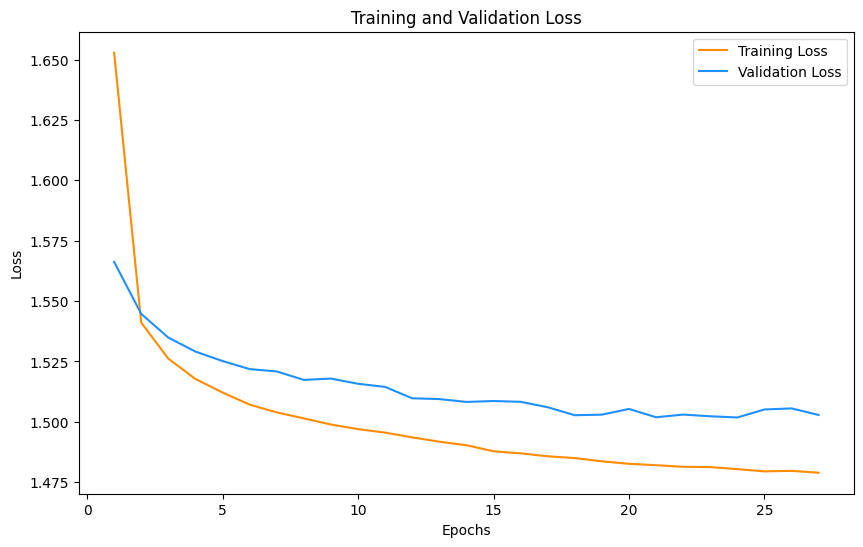

In [17]:
# start by defining a model that we are going to analyze and change

##
# this function is used to train the neural network that we are going to be using for classification of the items that 
# we are considering for insurance and for prisoners
def train_model(model, train_loader, val_loader, loss_function, optimizer, epochs=10, patience=2):
    best_val_loss = float('inf')
    patience_counter = 0

    # lists to store loss values for plotting
    train_losses = []
    val_losses = []
    epochs_list = []


    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        # print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

        train_losses.append(epoch_loss)
        val_losses.append(epoch_val_loss)
        epochs_list.append(epoch + 1)

        # check if the validation loss improved
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        
        else:
            patience_counter += 1

        # check for early stopping
        if patience_counter > patience:
            print("Stopping early due to increasing validation loss.")
            break

        # print the statistics from this epoch
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

    # plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_list, train_losses, label='Training Loss', color=PLOT_COLOR_1)
    plt.plot(epochs_list, val_losses, label='Validation Loss', color=PLOT_COLOR_2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if SHOULD_SAVE_OUTPUT:
        plt.savefig(os.path.join(WRITE_DIR, "nn_loss.png"))

    plt.show()


# define the loss function and optimizer that we are going to be using to train the neural network
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

# training the model
train_model(baseline_model, train_loader, val_loader, loss_function, optimizer, epochs=30)

# saving the model to a state dictionary
torch.save(baseline_model, os.path.join(WRITE_DIR, BASELINE_SAVE_FILE_NAME))

In [18]:
# starting from index zero for each
# this is the last PCA component
# in the first layer
FEATURE_NUM = 7
LAYER_NUM = 0


# this function computes the relevance of a single node+feature combination in the neural network
# layer_num: this is the layer number of the node that we are targeting
# feature_num: the number of the node that we want to minimize the importance of
# def compute_single_feature_importance(input_model, data_loader, layer_num, feature_num):
def compute_importance_GRAD(input_model, data_loader):

	# go through and get the one-hot importance of each input
	loss_func = nn.CrossEntropyLoss()

	# setting model to train
	input_model.train()
		
	# array to keep track of all of the gradients in the model
	total_gradient_list = None

	# the number of batches that we consider
	number_considered = 0

	# compute the gradients
	for input_data, input_label in data_loader:
		
		# keep track of the gradients of this instance
		instance_grads = []

		# set the gradients of the model to zero
		input_model.zero_grad()

		# get the output from the model
		model_guess = input_model(input_data)

		# compute the loss
		r_loss = loss_func(model_guess, input_label)

		# backpropagate the error
		r_loss.backward()

		# keep track of the gradients
		for name, param in input_model.named_parameters():

			# check if this is something that we should consider
			if 'weight' in name and param.grad is not None:

				# store the abs gradients
				# print(f"Grad shpae: {param.grad.abs().shape}")
				instance_grads.append(param.grad.abs() * param.data.abs())
				
				# if param.data.abs().shape == (32, 10):
				# 	print(param.grad.abs())
				# 	print(param.data.abs())
				# 	print(instance_grads[-1])
				# 	# print('hi')
				# 	return


		# check if this is an empty list
		if total_gradient_list is None:

			# add all of the gradients together
			total_gradient_list = []

			for l_idx, instance_entry in enumerate(instance_grads):

				# create zero versions of all of the gradient entries
				total_gradient_list.append(torch.zeros_like(instance_entry.mean(dim=0)))

		# update the total gradient list
		for l_idx, instance_entry in enumerate(instance_grads):

			# add the mean of the gradient
			# total_gradient_list[l_idx] += torch.clamp(instance_entry, min=0).mean(dim=0)
			# print(instance_entry.shape)
			# print(torch.abs(instance_entry).mean(dim=0).shape)
			# print(instance_entry)
			# print(torch.abs(instance_entry).mean(dim=0))
			# print(l_idx)
			total_gradient_list[l_idx] += torch.abs(instance_entry).mean(dim=0)

		# increment the number of examples that we have considered
		number_considered += 1

		# if number_considered > 10:
		# 	print(total_gradient_list)
		# 	break

	# average out the relevances
	total_gradient_list = [relevance / (number_considered) for relevance in total_gradient_list]

	# dot with the weights

	# normalize all of the layers
	total_gradient_list = [t_layer / t_layer.sum() for t_layer in total_gradient_list]

	# return the initial layer relevance
	# total_gradient_list.reverse()
	return [r.cpu().numpy() for r in total_gradient_list]	




# define a function to get the importance of some input feature or node that we want to target
# it effectively uses a method for layer relevance propagation
# and takes the average relevance over all of the input data that we can give it
# input_model: this is the model that we are going to compute the importance in 
def compute_importance_LRP(input_model, data_loader):

	# go through and get the one-hot importance of each input
	# loss_func = nn.CrossEntropyLoss()

	input_model.eval()

	# go through and add the hooks that take care of logging the activations
	# and the outputs of the layers that we are considering
	layer_activations = []

	all_layer_avg_relevances = None
	number_considered = 0

	# this adds a hook to each layer of the model to get the activation
	def forward_hook(module, input, output):

		# add to the linear and relus only
		if isinstance(module, nn.ReLU) or isinstance(module, nn.Linear):
			layer_activations.append(output)


	# add the hooks to the model
	model_layer_hooks = []

	# iterate the layers
	for layer in input_model.modules():

		if isinstance(layer, nn.ReLU) or isinstance(layer, nn.Linear):
			
			# register the hook
			t_hook = layer.register_forward_hook(forward_hook)
			model_layer_hooks.append(t_hook)


	# setting model to train
	input_model.train()
		
	# array to keep track of all of the gradients in the model
	total_gradient_list = []

	# compute the gradients
	for input_data, input_label in data_loader:

		# set the gradients of the model to zero
		input_model.zero_grad()

		# # get the output from the model
		# model_guess = input_model(input_data)

		# # compute the loss
		# r_loss = loss_func(model_guess, input_label)

		# # backpropagate the error
		# r_loss.backward()

		# # keep track of the gradients
		# for param in input_model.parameters():
				
		# 		# check if this is something that we should consider
		# 		if param.grad is not None:
					
		# 			# store the abs gradients
		# 			total_gradient_list.append(param.grad.abs())

		# get no gradient
		with torch.no_grad():
			
			# get the output from the model
			model_guess = input_model(input_data)
		
		# now get the relevance with respect to this input and update the mean values
		layer_relevance = model_guess
		instance_total_layer_activations = [layer_relevance.clone().mean(dim=0)]

		
		# # initialize all of the relevances if this has not been called yet
		# if all_layer_avg_relevances is None:
		# 	all_layer_avg_relevances = [torch.zeros_like(act) for act in layer_activations]

		# getting the number of activations
		# print(f"Number of layer activations: {len(layer_activations)}")
		

		# iterate through all of the possible activations in the model
		for i in range(len(layer_activations)-1, -1, -1):

			# print(f"Checking layer {i}")

			# get the current and previous activations to get the relevance
			current_activation = layer_activations[i]
			previous_activation = layer_activations[i-1] if i > 0 else input_data

			# get the current layer of the model
			current_layer = list(input_model.children())[i]

			# look for the linear weights to propagate the relevance
			if isinstance(current_layer, nn.Linear):
				
				# get the weights of the model
				weights = current_layer.weight.data

				# this applies the z-rule to the layer to compute the resulting relevances
				# print(f"processing: {previous_activation.shape} {torch.clamp(weights, min=0).T.shape}")
				z_rule_z_val = torch.matmul(previous_activation, torch.clamp(weights, min=0).T) + 1e-10
				z_rule_s_val = layer_relevance / z_rule_z_val
				z_rule_c_val = torch.matmul(z_rule_s_val, torch.clamp(weights, min=0))
				
				# propagate relevance to the previous layer
				layer_relevance = previous_activation * z_rule_c_val 
				
				# print(f"previous_activation length: {len(previous_activation)}")
				# print(f"z_rule_c_val: {z_rule_c_val.shape}")
				# print(f"layer_relevance shape: {layer_relevance.mean(dim=0).shape}")

			# add the relevance to the array
			instance_total_layer_activations.append(layer_relevance.mean(dim=0))

		
		
		# if we have not added anything then just make these values the relevance values
		if not all_layer_avg_relevances:
			# all_layer_avg_relevances = instance_total_layer_activations
			all_layer_avg_relevances = [torch.zeros_like(a) for a in instance_total_layer_activations]
		
		# otherwise then compute the new averages
		for l_idx, layer_rel in enumerate(instance_total_layer_activations):
			
			# print(f"{instance_total_layer_activations[l_idx].shape}")
			all_layer_avg_relevances[l_idx] += layer_rel.mean(dim=0)

		# increment the number of examples that we have considered
		number_considered += 1

		# clear the layer activations
		layer_activations.clear()

	# average out the relevances
	dat, _ = next(iter(data_loader))
	batch_size = dat.shape[0]
	all_layer_avg_relevances = [relevance / (number_considered) for relevance in all_layer_avg_relevances]


	# remove all of the hooks from the model
	for t_hook in model_layer_hooks:
		t_hook.remove()

	# return the initial layer relevance
	all_layer_avg_relevances.reverse()
	return [r.cpu().numpy() for r in all_layer_avg_relevances]	




# first bit of importance computation
initial_importance = compute_importance_GRAD(baseline_model, train_loader)
print(f"Initial importance of feature {FEATURE_NUM} in layer {LAYER_NUM}:")

for l_num in range(len(initial_importance)):
	print(f"{l_num} : {len(initial_importance[l_num])} | {sum(initial_importance[l_num]):.2f}")

# print the importance
print(f"Importance to output: {initial_importance[0][5]}")

print()
print(initial_importance[0])

Initial importance of feature 7 in layer 0:
0 : 10 | 1.00
1 : 32 | 1.00
2 : 16 | 1.00
Importance to output: 0.1268400400876999

[0.1388101  0.09843887 0.12981972 0.09996457 0.07852222 0.12684004
 0.08320011 0.07811422 0.08963289 0.07665721]


In [20]:
# now set a target node that we are going to try to minimize the effect of
# we are going to run each of the functions RUN_TIMES times to get an average time score
# method_function: the method that we are using to try to remove the influence. the arguments to the funciton are standardized
# input_model: this is the model that we want to remove the influence from
# layer: the layer that we want to be targeting with the influence depreciation
# node_num: the number node in the layer that we want to be limiting the influence of
# train_loader: this is the loader that we should be using to pull the training data
# val_loader: this is the validation dataset loader that we are going to use to evaluate the model
def remove_influence(method_function, input_model, layer, node_num, train_loader, val_loader, epochs=10, patience=2):

	# print the method that we ar eusing
	print(f"Removing influence with {method_function.__name__}")

	# the amount of time that it took for each iteration
	time_arr = []

	val_loss_arr = []
	train_loss_arr = []

	# keeping track of the importance of the input
	ret_importance_arr = []

	# make a copy of the input model
	new_input_model = copy.deepcopy(input_model)

	# measure the influence of the feature that we are trying to cancel on the model
	target_feature_initial_importance = compute_importance_GRAD(baseline_model, val_loader)[layer][node_num]

	# compute the metrics for the original model
	input_model.eval()
	orig_train_loss = 0.0
	with torch.no_grad():
		for inputs, labels in train_loader:
			outputs = input_model(inputs)
			loss = loss_function(outputs, labels)
			orig_train_loss += loss.item()
	orig_train_loss = orig_train_loss / len(train_loader)

	orig_val_loss = 0.0
	with torch.no_grad():
		for inputs, labels in val_loader:
			outputs = input_model(inputs)
			loss = loss_function(outputs, labels)
			orig_val_loss += loss.item()
	orig_val_loss = orig_val_loss / len(val_loader)

	
	# how many times are we going to run the operation
	for run_instance in range(RUN_TIMES):

		# get the timer going
		start_time = time.time()

		# run the function
		# each of the functions shoudl return a dictionary with at least the accuracy of the model that came out of the method
		ret_dict = method_function(input_model=new_input_model, layer=layer, node_num=node_num, train_loader=train_loader, val_loader=val_loader, epochs=epochs, patience=patience)

		# get the end time
		end_time = time.time()

		# add the val and train loss to the array
		val_loss_arr.append(ret_dict['best_val_loss'])
		train_loss_arr.append(ret_dict['train_loss'])
		ret_importance_arr.append(ret_dict['node_importance'])

		# add the seconds that it took to the time array
		time_arr.append(end_time - start_time)

	# get the average runtime
	avg_runtime	= np.array(time_arr).mean()
	avg_train_loss = np.array(train_loss_arr).mean()
	avg_val_loss = np.array(val_loss_arr).mean()
	avg_importance = np.array(ret_importance_arr).mean()

	# print how long that took
	print(f"Took {(avg_runtime):.4f} seconds on average for")
	print(f"avg_train_loss: {avg_train_loss:.4f} ({(100 * ((avg_train_loss - orig_train_loss) / orig_train_loss)):.2f}%)")
	print(f"avg_val_loss: {avg_val_loss:.4f} ({(100 * ((avg_val_loss - orig_val_loss) / orig_val_loss)):.2f}%)")
	print(f"importance: {(avg_importance):.4f} ({(100 * ((avg_importance - target_feature_initial_importance) / target_feature_initial_importance)):.2f}%)")
	print()

	return avg_runtime


# start with the easiest version -- simple retraining of the entire machine learning model
# each of these functions is going to return a dictionary that has all of the important metrics about the machine learning model
# since it doesn't make sense to remove a feature deeper in the machine learning model during simple retraining
# since that concept will just be represented in other nodes, we only do this for input features as a baseline
def simple_retraining(input_model=None, layer=None, node_num=None, train_loader=None, val_loader=None, epochs=10, patience=2, verbose=False):

	# check that the layer and the feature that we are changing the influence of are legitimate
 	# the layer is zero-indexed
	if layer is None:
		raise ValueError("Invalid layer passed to the function")

	if node_num is None:
		raise ValueError("Invalid node_num passed to the function")

	if train_loader is None:
		raise ValueError("Invalid train_loader passed to the function")

	if val_loader is None:
		raise ValueError("Invalid val_loader passed to the function")


	# neural network for the insurance dataset
	# as a baseline for the model
	class SimpleRetrainInsuranceNN(nn.Module):

		# initialize the insurance neural network item
		def __init__(self):
			super(SimpleRetrainInsuranceNN, self).__init__()
			self.foward_1 = nn.Linear(t_input_shape - 1, 32)
			self.foward_2 = nn.Linear(32, 16)
			self.foward_3 = nn.Linear(16, NUM_CLASSES)   

		# go forward through the neural network
		def forward(self, x):
			x = F.relu(self.foward_1(x))
			x = F.relu(self.foward_2(x))
			x = self.foward_3(x)
			return x
		
	# initialize a new model 
	new_input_model = SimpleRetrainInsuranceNN()

	loss_function = nn.CrossEntropyLoss()
	optimizer = optim.Adam(new_input_model.parameters(), lr=0.001)

	# retrain the model blocking the one input
	best_val_loss = float('inf')
	patience_counter = 0

	# lists to store loss values for plotting
	train_losses = []
	val_losses = []
	epochs_list = []

	for epoch in range(epochs):
		new_input_model.train()
		running_loss = 0.0

		for inputs, labels in train_loader:

			inputs = torch.cat((inputs[:, :node_num], inputs[:, node_num+1:]), dim=1)
			
			optimizer.zero_grad()
			outputs = new_input_model(inputs)
			loss = loss_function(outputs, labels)
			loss.backward()
			optimizer.step()
			running_loss += loss.item()

		new_input_model.eval()
		val_loss = 0.0
		with torch.no_grad():
			for inputs, labels in val_loader:

				inputs = torch.cat((inputs[:, :node_num], inputs[:, node_num+1:]), dim=1)
				outputs = new_input_model(inputs)
				loss = loss_function(outputs, labels)
				val_loss += loss.item()

		epoch_loss = running_loss / len(train_loader)
		epoch_val_loss = val_loss / len(val_loader)
		# print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

		train_losses.append(epoch_loss)
		val_losses.append(epoch_val_loss)
		epochs_list.append(epoch + 1)

		# check if the validation loss improved
		if epoch_val_loss < best_val_loss:
			best_val_loss = epoch_val_loss
			patience_counter = 0
		
		else:
			patience_counter += 1

		# check for early stopping
		if patience_counter > patience and verbose:
			print("Stopping early due to increasing validation loss.")
			break

		# print the statistics from this epoch
		if verbose:
			print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

	# return a dictionary with the final values that are important
	return {
		'best_val_loss': best_val_loss,
		'train_loss': running_loss / len(train_loader),
		'val_loss': val_loss / len(val_loader),
		'node_importance': 0, # if the input is not there then it literally cannot have influence on the output
	}



# now do stochastic fine-tuning to see what the impact on the influence of the input feature is
def stochastic_fine_tuning(input_model=None, layer=None, node_num=None, train_loader=None, val_loader=None, epochs=10, patience=2, verbose=False):

	# check that the layer and the feature that we are changing the influence of are legitimate
 	# the layer is zero-indexed
	if layer is None: 
		raise ValueError("Invalid layer passed to the function")
	
	if input_model is None: 
		raise ValueError("Invalid input_model passed to the function")

	if node_num is None:
		raise ValueError("Invalid node_num passed to the function")

	if train_loader is None:
		raise ValueError("Invalid train_loader passed to the function")

	if val_loader is None:
		raise ValueError("Invalid val_loader passed to the function")


	loss_function = nn.CrossEntropyLoss()
	optimizer = optim.Adam(input_model.parameters(), lr=0.001)

	# computing the mean of the feature that we are trying to limit the influence of across the entire dataset
	total_sum = 0
	total_count = 0
	input_model.eval() 
	with torch.no_grad():
		for inputs, _ in train_loader:
			total_sum += inputs[:, node_num].sum()
			total_count += inputs[:, node_num].numel()
	global_mean = total_sum / total_count

	# retrain the model blocking the one input
	best_val_loss = float('inf')
	patience_counter = 0

	# lists to store loss values for plotting
	train_losses = []
	val_losses = []
	epochs_list = []

	for epoch in range(epochs):
		input_model.train()
		running_loss = 0.0

		for inputs, labels in train_loader:

			# replace the feature that we are removing with a random variable
			inputs[:, node_num] = torch.randn_like(inputs[:, node_num]) + global_mean
			
			optimizer.zero_grad()
			outputs = input_model(inputs)
			loss = loss_function(outputs, labels)
			loss.backward()
			optimizer.step()
			running_loss += loss.item()

		input_model.eval()
		val_loss = 0.0
		with torch.no_grad():
			for inputs, labels in val_loader:

				# replace the feature that we are removing with a random variable
				inputs[:, node_num] = torch.randn_like(inputs[:, node_num]) + global_mean

				outputs = input_model(inputs)
				loss = loss_function(outputs, labels)
				val_loss += loss.item()

		epoch_loss = running_loss / len(train_loader)
		epoch_val_loss = val_loss / len(val_loader)
		# print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

		train_losses.append(epoch_loss)
		val_losses.append(epoch_val_loss)
		epochs_list.append(epoch + 1)

		# check if the validation loss improved
		if epoch_val_loss < best_val_loss:
			best_val_loss = epoch_val_loss
			patience_counter = 0
		
		else:
			patience_counter += 1

		# check for early stopping
		if patience_counter > patience and verbose:
			print("Stopping early due to increasing validation loss.")
			break

		# print the statistics from this epoch
		if verbose:
			print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')


	# compute the importance of the feature that we are trying to limit the influence of
	node_importance = compute_importance_GRAD(input_model, val_loader)[layer][node_num]

	# return a dictionary with the final values that are important
	return {
		'best_val_loss': best_val_loss,
		'train_loss': running_loss / len(train_loader),
		'val_loss': val_loss / len(val_loader),
		'node_importance': node_importance,
	}




# now do inversion fine-tuning where we try to remove the information that is contained in 
# the variable from the model training
def inversion_fine_tuning(input_model=None, layer=None, node_num=None, train_loader=None, val_loader=None, epochs=10, patience=2, verbose=False):

	# check that the layer and the feature that we are changing the influence of are legitimate
 	# the layer is zero-indexed
	if layer is None: 
		raise ValueError("Invalid layer passed to the function")
	
	if input_model is None: 
		raise ValueError("Invalid input_model passed to the function")

	if node_num is None:
		raise ValueError("Invalid node_num passed to the function")

	if train_loader is None:
		raise ValueError("Invalid train_loader passed to the function")

	if val_loader is None:
		raise ValueError("Invalid val_loader passed to the function")


	loss_function = nn.CrossEntropyLoss()
	optimizer = optim.Adam(input_model.parameters(), lr=0.001)

	# computing the mean of the feature that we are trying to limit the influence of across the entire dataset
	total_sum = 0
	total_count = 0
	input_model.eval() 
	with torch.no_grad():
		for inputs, _ in train_loader:
			total_sum += inputs[:, node_num].sum()
			total_count += inputs[:, node_num].numel()
	global_mean = total_sum / total_count

	# retrain the model blocking the one input
	best_val_loss = float('inf')
	patience_counter = 0

	# lists to store loss values for plotting
	train_losses = []
	val_losses = []
	epochs_list = []

	# go through some amount of epochs
	for epoch in range(epochs):
		input_model.train()
		running_loss = 0.0

		for inputs, labels in train_loader:

			# replace the feature that we are removing with the inversion across the mean
			# of the variable in a similar fashion to grover's
			inputs[:, node_num] = inputs[:, node_num].mean() - 2 * (inputs[:, node_num] - global_mean)
			
			optimizer.zero_grad()
			outputs = input_model(inputs)
			loss = loss_function(outputs, labels)
			loss.backward()
			optimizer.step()
			running_loss += loss.item()

		input_model.eval()
		val_loss = 0.0
		with torch.no_grad():
			for inputs, labels in val_loader:

				# replace the feature that we are removing with the inversion across the mean
				# of the variable in a similar fashion to grover's
				inputs[:, node_num] = inputs[:, node_num].mean() - 2 * (inputs[:, node_num] - global_mean)

				outputs = input_model(inputs)
				loss = loss_function(outputs, labels)
				val_loss += loss.item()

		epoch_loss = running_loss / len(train_loader)
		epoch_val_loss = val_loss / len(val_loader)
		# print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

		train_losses.append(epoch_loss)
		val_losses.append(epoch_val_loss)
		epochs_list.append(epoch + 1)

		# check if the validation loss improved
		if epoch_val_loss < best_val_loss:
			best_val_loss = epoch_val_loss
			patience_counter = 0
		
		else:
			patience_counter += 1

		# check for early stopping
		if patience_counter > patience and verbose:
			print("Stopping early due to increasing validation loss.")
			break

		# print the statistics from this epoch
		if verbose:
			print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')


	# compute the importance of the feature that we are trying to limit the influence of
	node_importance = compute_importance_GRAD(input_model, val_loader)[layer][node_num]

	# return a dictionary with the final values that are important
	return {
		'best_val_loss': best_val_loss,
		'train_loss': running_loss / len(train_loader),
		'val_loss': val_loss / len(val_loader),
		'node_importance': node_importance,
	}


# greedy_amplitude_correlation_adjustment essentially measures the correlation between amplitudes in the layer 
# just before the layer that we are trying to remove a node's influence from. Essentially, if there is a ndoe that we
# are trying to remove the influence of located in layer i, then change the weights for all of the input nodes to 
# layer i+1 to remove the influence while maintaining the fidelity of the outputs of the layer
def greedy_amplitude_correlation_adjustment(input_model=None, layer=None, node_num=None, train_loader=None, val_loader=None, epochs=10, patience=2, verbose=False, max_correlation_elements=3):

	# check that the layer and the feature that we are changing the influence of are legitimate
 	# the layer is zero-indexed
	if layer is None: 
		raise ValueError("Invalid layer passed to the function")
	
	if input_model is None: 
		raise ValueError("Invalid input_model passed to the function")

	if node_num is None:
		raise ValueError("Invalid node_num passed to the function")

	if train_loader is None:
		raise ValueError("Invalid train_loader passed to the function")

	if val_loader is None:
		raise ValueError("Invalid val_loader passed to the function")

	# define the loss and the optimizer that we want to use
	loss_function = nn.CrossEntropyLoss()
	optimizer = optim.Adam(input_model.parameters(), lr=0.001)

	# clear the information
	node_importance_clear_total_run()

	# register hooks and go through the model to get the intermediate outptus
	node_importance_register_hooks(input_model)

	# go through each of the training data pieces and get the correlations
	with torch.no_grad():
		for inputs, labels in train_loader:

			node_importance_start_new_pass_through_with_input(inputs)

			# get the output of the model
			outputs = input_model(inputs)

			node_importance_save_and_clear_influence_network_current_pass_through()

	# get the layer outputs of the model
	model_layer_outputs = node_importance_retrieve_and_return_entire_network_outputs()

	# stack all of the arrays to get the correlation
	stacked_arr = None

	# stack all of the arrays
	for batch_arr in [t_outs[layer] for t_outs in model_layer_outputs]:
		if stacked_arr is None:
			stacked_arr = batch_arr
		else:
			stacked_arr = torch.cat((stacked_arr, batch_arr), dim=0)

	# print(f"stacked_arr shape: {stacked_arr.shape}")

	# run a regresison between the banned feature and all of the other features
	# to get the optimal construction
	t_data = copy.deepcopy(stacked_arr)

	# create the data for a regression
	y = t_data[:, node_num]  
	X = np.delete(t_data, node_num, axis=1)

	# create the regression
	model = LinearRegression(fit_intercept=False)
	model.fit(X, y)

	# checking the residuals
	resid_pred = model.predict(X)
	mean_resids = mean_absolute_error(y, resid_pred)


	# print(f"Residual Error: {mean_resids}")
	# print(y)
	# print(resid_pred)

	# get the coefficients of the regression
	reg_coef = np.array(model.coef_)


	# now for the layer that we are considering we are greedily going to change the weights
	# to roughly approximate the old weight
	# print(f"Shape of layer: {input_model.foward_1.weight.data.shape}")
	# print(f"Reg Coeffs: {reg_coef}")

	example_input, _ = next(iter(train_loader))
	example_input = example_input[0]
	new_weights = copy.deepcopy(input_model.foward_1.weight.data)

	# for each of the columns add reg_weight[i] * orig_banned_weight[i] to approximate the offset
	for row_idx in range(len(input_model.foward_1.weight.data)):

		# get the offset that is associated with the regression
		offset = 0

		# iterate through each of the rows now
		for col_idx in range(len(input_model.foward_1.weight.data[node_num]) - 1):

			# # check which node we are offsetting
			# if col_idx == node_num:
			# 	offset += 1
			
			# # adjust the weight
			# # print(f" {row_idx} | {col_idx + offset} : {(reg_coef[col_idx] * new_weights[node_num][col_idx + offset])}")
			# new_weights[row_idx][col_idx + offset] = new_weights[row_idx][col_idx + offset] + (reg_coef[col_idx] * new_weights[node_num][col_idx + offset])
   
			if col_idx != node_num:
				new_weights[row_idx][col_idx] += reg_coef[col_idx - (1 if col_idx > node_num else 0)] * new_weights[row_idx][node_num]

		# set the other weights to zero for the original input
		new_weights[row_idx][node_num] = 0

	# update the weights
	input_model.foward_1.weight.data = new_weights


	# new_weights[:, node_num] = 0

	# print()
	# print(example_input)
	# print()

	# for row_idx in range(len(input_model.foward_1.weight.data)):
	# 	for col_idx in range(len(input_model.foward_1.weight.data[node_num])):
	# 		print(f"{(input_model.foward_1.weight.data)[row_idx][col_idx]} | {(new_weights)[row_idx][col_idx]}")

	# orig_output = example_input @ input_model.foward_1.weight.data.T
	# new_output = example_input @ input_model.foward_1.weight.data.T

	# print(orig_output)
	# print(new_output)
	# print(orig_output - new_output)

	# for row in (input_model.foward_1.weight.data):
	# 	print(row)

	# print the reconstruction and correlation indexes
	# print(f'Attempting to reconstruct ')




	# retrain the model blocking the one input
	best_val_loss = float('inf')
	patience_counter = 0

	# lists to store loss values for plotting
	train_losses = []
	val_losses = []
	epochs_list = []

	# run a few epochs while blocking the gradient for the bad input
	for epoch in range(epochs):
		
		input_model.train()
		running_loss = 0.0

		for inputs, labels in train_loader:

			optimizer.zero_grad()
			outputs = input_model(inputs)
			loss = loss_function(outputs, labels)
			loss.backward()
			optimizer.step()
			running_loss += loss.item()

		# set some of the weights to zero
		input_model.foward_1.weight.data[:, node_num] = 0

		input_model.eval()
		val_loss = 0.0
		with torch.no_grad():
			for inputs, labels in val_loader:

				outputs = input_model(inputs)
				loss = loss_function(outputs, labels)
				val_loss += loss.item()

		epoch_loss = running_loss / len(train_loader)
		epoch_val_loss = val_loss / len(val_loader)
		# print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')

		train_losses.append(epoch_loss)
		val_losses.append(epoch_val_loss)
		epochs_list.append(epoch + 1)

		# check if the validation loss improved
		if epoch_val_loss < best_val_loss:
			best_val_loss = epoch_val_loss
			patience_counter = 0
		
		else:
			patience_counter += 1

		# check for early stopping
		if patience_counter > patience and verbose:
			print("Stopping early due to increasing validation loss.")
			break

		# print the statistics from this epoch
		if verbose:
			print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val Loss: {epoch_val_loss}')


	# placing the model in evaluation mode
	input_model.eval()
	val_loss = 0.0
	with torch.no_grad():
		for inputs, labels in val_loader:

			outputs = input_model(inputs)
			loss = loss_function(outputs, labels)
			val_loss += loss.item()


	# compute the importance of the feature that we are trying to limit the influence of
	node_importance = compute_importance_GRAD(input_model, val_loader)
	target_importance = node_importance[layer][node_num]


	# return a dictionary with the final values that are important
	return {
		'best_val_loss': best_val_loss,
		'train_loss': running_loss / len(train_loader),
		'val_loss': val_loss / len(val_loader),
		'node_importance': target_importance,
	}

	
# define the loss function and optimizer that we are going to be using to train the neural network

# for feat_num in [0, 5, 7, 9]:
for feat_num in range(10):

	print(f"RESULTS FOR REMOVING FEATURE {feat_num} INFLUENCE:")

	# try each of the methods
	avg_inversion_retrain_time = remove_influence(greedy_amplitude_correlation_adjustment, baseline_model, layer=LAYER_NUM, node_num=FEATURE_NUM, train_loader=train_loader, val_loader=val_loader, epochs=5)

	avg_stochastic_retrain_time = remove_influence(stochastic_fine_tuning, baseline_model, layer=LAYER_NUM, node_num=FEATURE_NUM, train_loader=train_loader, val_loader=val_loader, epochs=5)
	avg_inversion_retrain_time = remove_influence(inversion_fine_tuning, baseline_model, layer=LAYER_NUM, node_num=FEATURE_NUM, train_loader=train_loader, val_loader=val_loader, epochs=5)
	avg_simple_retrain_time = remove_influence(simple_retraining, baseline_model, layer=LAYER_NUM, node_num=FEATURE_NUM, train_loader=train_loader, val_loader=val_loader, epochs=30)

	print()

torch.Size([64, 10])
RESULTS FOR REMOVING FEATURE 0 INFLUENCE:
Removing influence with greedy_amplitude_correlation_adjustment
Took 3.6363 seconds on average for
avg_train_loss: 1.4848 (0.67%)
avg_val_loss: 1.5313 (1.90%)
importance: 0.0000 (-100.00%)

Removing influence with stochastic_fine_tuning
Took 3.1858 seconds on average for
avg_train_loss: 1.4973 (1.55%)
avg_val_loss: 1.5212 (1.23%)
importance: 0.0273 (-65.93%)

Removing influence with inversion_fine_tuning
Took 3.2662 seconds on average for
avg_train_loss: 1.4832 (0.56%)
avg_val_loss: 1.5035 (0.05%)
importance: 0.0620 (-22.73%)

Removing influence with simple_retraining
Took 16.9821 seconds on average for
avg_train_loss: 1.4954 (1.43%)
avg_val_loss: 1.5177 (0.99%)
importance: 0.0000 (-100.00%)


RESULTS FOR REMOVING FEATURE 1 INFLUENCE:
Removing influence with greedy_amplitude_correlation_adjustment
Took 3.5472 seconds on average for
avg_train_loss: 1.4847 (0.67%)
avg_val_loss: 1.5306 (1.85%)
importance: 0.0000 (-100.00%)

Re

### Old Code:

This was the original dynamic programming approach that was used to find the optimal weighting of the original inputs. I found that the linear regression approach detailed above is more effective. 

In [ ]:
# define a sub-function that uses a dynamic programming approach to find the set of elements that
# when summed has a correlation closest to the original input
# corr_arr: has the correlation values of all of the other elements in the array
# max_correlation_elements: the maximum number of elements that we are allowed to use to reconstruct the correlation
# orig_weight_ind: the index of the original banned feature (do not use)
def find_closest_sum_dp(corr_arr, max_correlation_elements, orig_weight_ind):

	# define a base case
	closest = {}
	closest[(0, 0)] = (0, [])

	# check each correlation value in the correlation array
	for idx, corr_val in enumerate(corr_arr):

		# do not consider the index that contains the original weight
		if idx == orig_weight_ind:
			continue
		
		# keep track of the current sums
		updates = []

		# check the rest of the sums
		for (count, sum_so_far), (current_closest, indices) in closest.items():

			# make sure that we don't add too many elements
			if count + 1 > max_correlation_elements: 
				continue

			# check the new summation value
			new_sum = sum_so_far + corr_val
			new_indices = indices.append(idx)

			# create the key that we can use to index
			new_key = (count + 1, new_sum)
			
			# check if this is better than before
			if new_key not in closest or abs(1 - new_sum) < abs(1 - closest[new_key]):
				updates.append((new_key, (new_sum, new_indices)))

		# update the dictionary
		for key, value in updates:
			closest[key] = value

	# find the closest sum to 1 from all entries considering up to m elements
	closest_to_one = None
	min_difference = float('inf')
	best_indices = []
	
	# find the element that adheres to the maximum values condition
	for (count, sum_so_far), (sum_value, t_ind) in closest.items():

		# return and update the best value
		if count <= max_correlation_elements and abs(1 - sum_value) < min_difference:
			min_difference = abs(1 - sum_value)
			closest_to_one = sum_value
			best_indices = t_ind

	# return the best combination
	return (closest_to_one, best_indices)


# # for the feature that we are trying to limit the influence of get the correlation
# banned_feature_corr = correlation_matrices[layer][node_num]

# # get the best correlations
# (reconstructed_correlation, reconstruction_indexes) = find_closest_sum_dp(banned_feature_corr, max_correlation_elements, node_num)
